# One-shot learning implementation for fish recognition
Using the [fish4knowledge Fish Recognition Ground-Truth dataset](https://github.com/brendenlake/omniglot/tree/master/python)

### TODO
- data augmentation ?
- other optimizers ?
- comparer avec et sans
  - batch norm
  - batch norm au début
  - dropout
  - regul

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Setup phase
We install packages, make all imports, configure modules and download dataset

In [9]:
%%bash
pip install -q pyyaml
pip install tensorflow==2.0.0-beta1
pip install -q tensorflow-gpu==2.0.0-beta1

  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
%%bash
mkdir datas
unzip -q "/content/drive/My Drive/ml/datas/fishes_all_augmented.zip" -d datas

In [11]:
%load_ext tensorboard

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd
import numpy as np
import skimage
from skimage import transform as sktrans

from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models
from tensorboard import notebook
from keras import backend as K
from IPython import display

import os, datetime, time, math, pathlib, itertools, random

keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.version.VERSION)
print(tf.keras.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta1
2.2.4-tf
GPU Available:  True


## Constants
This part will define how to build, train, and evaluate the model

In [12]:
#@markdown ## Data paths
DIR_DATAS = "datas/fishes_all_augmented" #@param {type:"string"}
LOAD_FROM = ""  #@param ["", "save_dir"] {allow-input: true}
CHECKPOINTS_DIR = "drive/My Drive/ml/weights/fishes" #@param {type:"string"}
checkpoint_dir_name = "checkpoint_" + str(int(time.time()))


#@markdown ## Model configuration
MODEL_TYPE = "conv_light" #@param ["dense", "conv", "conv_2", "conv_3", "conv_light"]
IMG_SIDE = 100 #@param {type:"slider", min:10, max:300, step:1}
# -> [96, 128, 160, 192, 224]
IMG_SHAPE = (IMG_SIDE, IMG_SIDE, 3)
NB_CLASSES = 23 #@param {type:"number"}

#@markdown ## Training configuration
NB_EPOCHS = 40 #@param {type:"number"}
BATCH_SIZE = 32 #@param {type:"number"}
TRIPLETS_PER_IMAGE = 10 #@param {type:"number"}
LEARNING_RATE = 0.001 #@param {type:"number"}
L2_REGUL = 1e-4 #@param {type:"number"}

#@markdown ## Evaluation configuration


checkpoint_dir_name = "checkpoint_" + MODEL_TYPE
print("Saving in {} for this session".format(checkpoint_dir_name))
if LOAD_FROM:
  print("Loading weights from checkpoint {}".format(LOAD_FROM))

Saving in checkpoint_conv_light for this session


## General code
Helper functions

In [0]:
def get_checkpoint_path(suffix=""):
  os.makedirs(os.path.join(CHECKPOINTS_DIR, checkpoint_dir_name), exist_ok=True)
  return os.path.join(
    CHECKPOINTS_DIR,
    checkpoint_dir_name,
    "weights" + suffix + ".hdf5"
  )

In [0]:
class Timer():
  def __init__(self, to_int = True):
    self.t = time.time()
    self.to_int = to_int
  
  def get(self, reset=True):
    t2 = time.time()
    d = t2 - self.t
    if self.to_int:
      d = int(d)
    if reset:
      self.t = t2
    return d

In [0]:
def show_image(image):
	plt.imshow(image)
	plt.show()

## Import datas and pre-processing

In [0]:
def img_to_rgb(image):
  if len(image.shape) == 3 and image.shape[2] == 3:
    return image
  if len(image.shape) == 3:
    image = image.reshape(image.shape[:2])
  return skimage.color.grey2rgb(image)

def reshape_image(image):
  h, w = image.shape[0], image.shape[1]
  scale = min(IMG_SHAPE[0]/h, IMG_SHAPE[1]/w)
  padH = round((IMG_SHAPE[0] / scale - h) / 2)
  padW = round((IMG_SHAPE[1] / scale - w) / 2)

  padShape = ((padH, padH), (padW, padW), (0,0))
  image = skimage.util.pad(image, padShape, 'constant')

  return skimage.transform.resize(image, IMG_SHAPE, mode='symmetric', preserve_range=True)

def preprocess_image(tf_image):
  tf_image = tf.image.decode_image(tf_image)
  # tf_image = tf.image.resize(tf_image, IMG_SHAPE)
  image = tf_image.numpy().astype(float).reshape(tf_image.shape) / 255.0
  image = img_to_rgb(image)
  image = reshape_image(image)
  return image

def load_and_preprocess_image(img_path):
  return preprocess_image(tf.io.read_file(str(img_path)))

In [0]:
def get_datas_paths(dir_path, subdir):
  fish_classes = sorted([s for s in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, s))])
  fish_dirs = [os.path.join(dir_path, cls, subdir) for cls in fish_classes]
  img_infos = [
      [(os.path.join(cls_path, img_f_name), label) for img_f_name in os.listdir(cls_path)]
      for cls_path, label in zip(fish_dirs, list(range(len(fish_dirs))))
  ]
  img_infos = list(itertools.chain(*img_infos))
  paths, labels = [[el[i] for el in img_infos] for i in range(2)]
  return paths, labels, fish_classes # len : nb images | nb images | nb classes

def load_datas(dir_path, subdir):
  paths, labels, cls_names = get_datas_paths(dir_path, subdir)
  images_datas = [load_and_preprocess_image(img_path) for img_path in paths]
  images_datas, labels = np.array(images_datas), np.array(labels)
  return images_datas, labels, cls_names

def get_subsets_per_cls(datas, labels, subsets=[None]):
  nb_cls = max(labels)+1
  subsets_datas = [[() for _ in subsets] for _ in range(nb_cls)]
  ids_per_cls = [[] for _ in range(nb_cls)]
  for i in range(len(datas)):
    ids_per_cls[labels[i]].append(i)
  
  for i_cls in range(nb_cls):
    for i_sub, max_datas in enumerate(subsets):
      if max_datas == None:
        max_datas = len(ids_per_cls[i_cls])
      subsets_datas[i_cls][i_sub] = ids_per_cls[i_cls][:max_datas]
      ids_per_cls[i_cls] = ids_per_cls[i_cls][max_datas:]
  split_datas = [([], []) for _ in subsets]
  for i_cls in range(nb_cls):
    for i_sub in range(len(subsets)):
      for i_img in subsets_datas[i_cls][i_sub]:
        split_datas[i_sub][0].append(datas[i_img])
        split_datas[i_sub][1].append(labels[i_img])
  return split_datas

Data augmentation

In [0]:
def flipH(img): return img[::, ::-1]
def flipV(img): return img[::-1]
def rotateImg(img, angle): return sktrans.rotate(img, angle, False)
def translateV_left(img, decal): return np.concatenate([img[::, decal::], np.zeros((IMG_SIDE, decal, 3))], axis=1)
def translateV_right(img, decal): return np.concatenate([np.zeros((IMG_SIDE, decal, 3)), img[::, :-decal]], axis=1)
def translateH_top(img, decal): return np.concatenate([img[decal:], np.zeros((decal, IMG_SIDE, 3))])
def translateH_bottom(img, decal): return np.concatenate([np.zeros((decal, IMG_SIDE, 3)), img[:-decal]])

In [0]:
FACTOR = {0 : 100, 10000: 0, 1000 : 0, 500: 3, 100: 8, 50: 10}

# Used locally
def augment_data(images, labels):
  by_label = [[] for _ in range(max(labels)+1)]
  images2, labels2 = list(images), list(labels)
  for img, lab in zip(images, labels):
    by_label[lab].append(img)
  for lab in range(len(by_label)):
    factor = 1000000
    for lim_min, fct in FACTOR.items():
      if lim_min <= len(by_label[lab]):
        factor = min(factor, fct)
    if fct <= 1:
      continue
    for i_img in range(len(by_label[lab])):
      img = by_label[lab][i_img]
      transfos = [flipH(img), flipV(img), flipH(flipV(img))]
      transfos += [rotateImg(img, random.randint(20, 340)) for _ in range(4)]
      random.shuffle(transfos)
      for img2 in transfos:
        images2.append(img2)
        labels2.append(lab)
      # by_label[lab].extend(transfos[:factor])
  return images2, labels2
  # TODO : directly push
  # return [np.array(k) for k in zip(*itertools.chain(*[[(a, b) for a in l] for b,l in enumerate(by_label)]))]

Now, we read all the datas

In [20]:
try:
  _ = test_images
except:
  train_images, train_labels, train_cls_names = load_datas(DIR_DATAS, "train")
  print(train_images.shape, train_labels.shape)
  test_images, test_labels, test_cls_names = load_datas(DIR_DATAS, "test")

print(len(train_images), train_images[0].shape, train_labels[0].shape)
print(test_images.shape, test_labels.shape)

(29755, 100, 100, 3) (29755,)
29755 (100, 100, 3) ()
(1480, 100, 100, 3) (1480,)


## Building model

### Base models

Model with only fully-connected layers

In [0]:
def create_dense_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    # layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(2048, activation='tanh'),
    layers.Dense(1024, activation='tanh'),
    # layers.Dense(512, activation='relu'),
    layers.Dense(NB_CLASSES, activation='softmax'),
  ], name="dense_model")
  return model

In [0]:
def get_regul():
  return keras.regularizers.l2(L2_REGUL)

Convolutional neural networks

In [0]:
def create_conv_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.BatchNormalization(),

    layers.Conv2D(20, (5, 5), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(40, (5, 5), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(80, (4, 4), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(1024, activation='tanh'),
    # layers.Dropout(0.2),
    layers.Dense(512, activation='tanh'),
    # layers.Dropout(0.2),
    layers.Dense(NB_CLASSES, activation='softmax')
  ], name="conv_model")
  return model

def create_conv_2_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.BatchNormalization(),

    layers.Conv2D(32, (5, 5), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (4, 4), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (4, 4), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(NB_CLASSES, activation='softmax')
  ], name="conv_2_model")
  return model

def create_conv_3_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (8, 8), activation='relu', padding="same"),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (4, 4), activation='relu', padding="same"),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (4, 4), activation='relu', padding="same"),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (4, 4), activation='relu', padding="same"),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(512, activation='tanh'),
    layers.Dense(NB_CLASSES, activation='softmax')
  ], name="conv_3_model")
  return model

def create_conv_light_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.BatchNormalization(),

    layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)), # kernel_regularizer=keras.regularizers.l2(1e-4)
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4, 4), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    # layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(NB_CLASSES, activation='softmax')
  ], name="conv_light")
  return model

### Building model

In [24]:
model = globals()["create_{}_model".format(MODEL_TYPE)]()
model.summary()

Model: "conv_light"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 100, 100, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 64)        2

If there's a model to restore, we will try to restore weights

In [25]:
if LOAD_FROM:
  if LOAD_FROM == "save_dir":
    LOAD_FROM = get_checkpoint_path()
  print("Load weights from", LOAD_FROM)
  # model.load_weights(LOAD_FROM)
  # model = tf.keras.models.load_model(LOAD_FROM)
  trunk_model.load_weights(LOAD_FROM)
else:
  print("No weights to load")

No weights to load


## Training phase

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  # optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=0.0001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [0]:
# !rm -R logs/*
# %tensorboard --logdir logs

In [28]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint_path = get_checkpoint_path(suffix="_1.7")
print("Saving weights at", checkpoint_path)

callbacks = [
  keras.callbacks.ModelCheckpoint(checkpoint_path, load_weights_on_restart=False),
  # keras.callbacks.TensorBoard(logdir, histogram_freq=1),
]

hist = model.fit(
  train_images, train_labels,
  epochs = 60,
  batch_size=BATCH_SIZE,
  callbacks=callbacks,
  validation_data=(test_images, test_labels)
)

Saving weights at drive/My Drive/ml/weights/fishes/checkpoint_conv_light/weights_1.7.hdf5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 29755 samples, validate on 1480 samples
Epoch 1/60
29755/29755 [==============================] - 23s 781us/sample - loss: 0.7484 - accuracy: 0.7858 - val_loss: 0.3957 - val_accuracy: 0.8885
Epoch 2/60
29755/29755 [==============================] - 17s 569us/sample - loss: 0.2817 - accuracy: 0.9214 - val_loss: 0.2777 - val_accuracy: 0.9284
Epoch 3/60
29755/29755 [==============================] - 17s 566us/sample - loss: 0.1830 - accuracy: 0.9507 - val_loss: 0.2391 - val_accuracy: 0.9365
Epoch 4/60
29755/29755 [==============================] - 17s 568us/sample - loss: 0.1308 - accuracy: 0.9659 - val_loss: 0.2116 - val_accuracy: 0.9426
Epoch 5/60
29755/29755 [==============================] - 17s 576us/sample - loss: 0.1018 - accuracy: 0.9750 - val_loss: 0.1782 - val_accuracy: 0.9493
Epoch 6/60
2

KeyboardInterrupt: ignored

## Functions to compute / plot stats about trained models

In [0]:
def eval_accuracy(model, images, labels):
  success = [False for _ in labels]
  predictions = model.predict(images, BATCH_SIZE)
  predictions = [p.argmax() for p in predictions]
  success = [a==b for a, b in zip(labels, predictions)]
  acc = sum(success) / len(images)
  return acc, success, predictions

In [0]:
def plot_history_key(histories, key='loss', color=None):
  plt.figure(figsize=(14,8))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' validation '+key, color=color)
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' train '+key)

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

def plot_history(history, name="", accuracy_key="accuracy"):
  history = [(name, history)]
  plot_history_key(history, "loss", color="blue")
  plot_history_key(history, accuracy_key, color="green")

In [0]:
def plot_hist(arrs):
  plt.figure(figsize=(12,5))
  plt.hist(arrs,
    bins = 60,
    color = ['blue', '#D72F1A'],
    # edgecolor = 'black',
    label=["Same dists", "Diff dists"],
    density=True
  )
  plt.legend(loc='upper right')

  plt.tight_layout()
  plt.show()

In [0]:
def plot_results_per_class(is_success, labels, cls_names):
  n_cls = len(cls_names)
  cls_success, cls_failed = [0]*n_cls, [0]*n_cls

  plt.figure(figsize=(14.5,6))

  for i, succ in enumerate(is_success):
    if succ == True:
      cls_success[labels[i]] += 1
    elif succ == False:
      cls_failed[labels[i]] += 1

  # cls_sum = [max(a+b, 1) for a, b in zip(cls_success, cls_failed)]
  # cls_success = [v / s for v, s in zip(cls_success, cls_sum)]
  # cls_failed = [v / s for v, s in zip(cls_failed, cls_sum)]
  
  ind = np.arange(n_cls)
  width = 0.8 # the width of the bars: can also be len(x) sequence
  rotation = 45 if n_cls < 60 else 90

  p1 = plt.bar(ind, cls_success, width, color="#4CAF50")
  p2 = plt.bar(ind, cls_failed, width, bottom=cls_success, color="#EF5350")

  plt.ylabel('Number of tests')
  plt.xlabel('Fish species')
  plt.title('Number of detection success and failure per fish species')
  plt.xticks(ind, cls_names, rotation=rotation)
  # plt.yticks(np.arange(0, 81, 10))
  plt.legend((p1[0], p2[0]), ('Success', 'Failed'))

  plt.show()

## Display trained model stats

In [0]:
# plot_history(hist)

===== TRAINING STATS =====
Accuracy : 99.95294908418754%


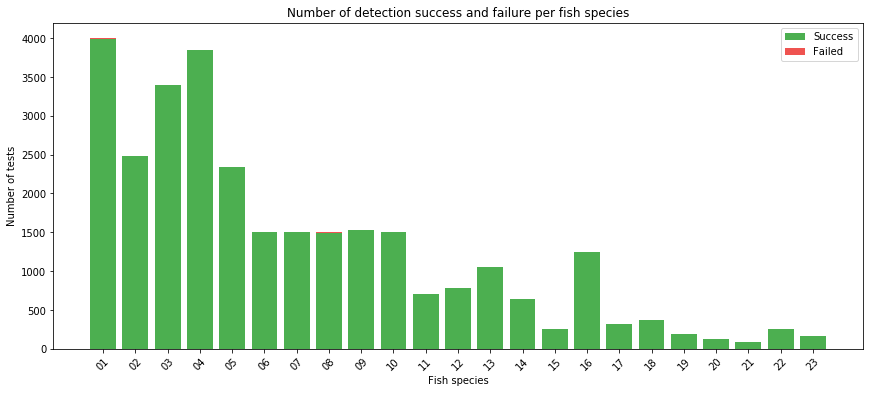

In [34]:
print("===== TRAINING STATS =====")
accuracy, good_results, predictions = eval_accuracy(model, train_images, train_labels)

print("Accuracy : {}%".format(accuracy*100))
plot_results_per_class(good_results, train_labels, train_cls_names)

===== TESTING STATS =====
Accuracy : 97.16216216216216%


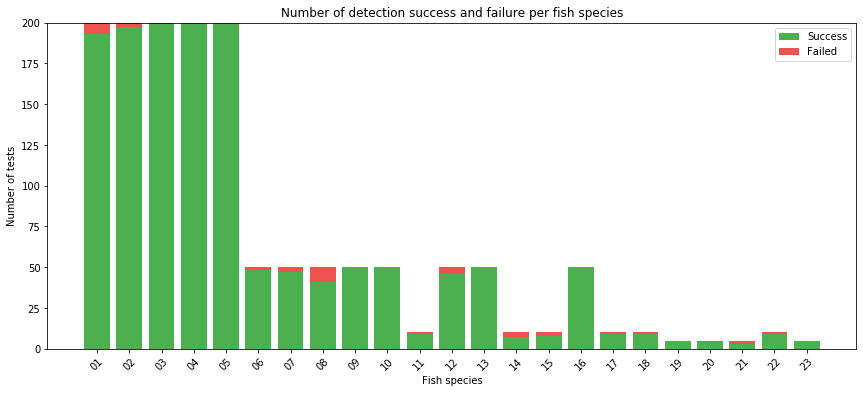

In [35]:
print("===== TESTING STATS =====")
accuracy, good_results, predictions = eval_accuracy(model, test_images, test_labels)

print("Accuracy : {}%".format(accuracy*100))
plot_results_per_class(good_results, test_labels, test_cls_names)